In [5]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

### Introduccion

Una regresion lineal es un modelo de prediccion de la forma: $Y=\theta X + b$

Se tiene un conjunto de datos $X$ que es la variable independiente y $Y$ que es el valor real que toma la situacion que se quiere modelar. De esta forma lo que se busca es $\theta$ y $b$ de tal forma que se pueda predecir el resultado de cualquier $x$ que no provenga de los datos originales $X$.

El problema anterior (hallar $\theta,b$) se puede resolver de forma analitica.

En el caso en que tengamos datos binarios, dummy, etc. ya no se puede usar una regresion lineal ya que esto nos regresaria un valor que no sabriamos interpretar como binario. Por ejemplo, podriamos alimentar al modelo calificaciones de los alumnos de una materia y con base en eso nos gustaria predecir si aprobaran o no el curso.

Para el caso de este tipo de problema tenemos que utilizar la funcion sigmoide. La cual esta definida como $f(z) =\displaystyle{\frac{1}{1 + e^{-z}}}$

In [6]:
def sigmoide(z):
    return (1 + np.exp(-z))**-1

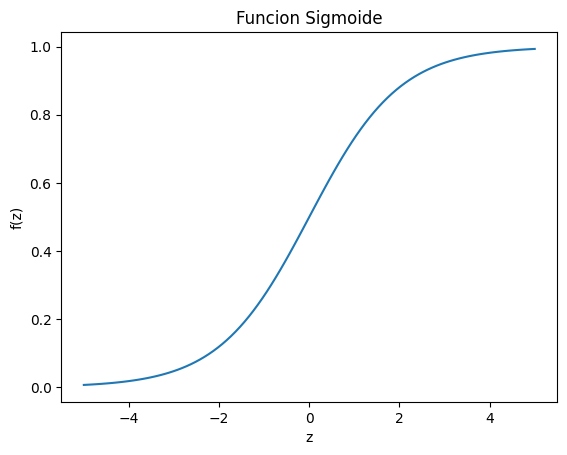

In [7]:
x_sigm = np.linspace(-5, 5, 102)
y_sigm = sigmoide(x_sigm)

plt.plot(x_sigm, y_sigm)
plt.ylabel("f(z)")
plt.xlabel("z")
plt.title("Funcion Sigmoide")
plt.show()

De esta forma, lo que alimentamos al modelo son datos $X$ y resultados $Y\in\{0,1\}$. Lo que se hace despues es definir una regresion lineal dentro de la funcion sigmoide $f(z)$.

De modo que lo que tenemos es un modelo de la forma $Y=f(\theta X + b)$ donde $f$ es la funcion sigmoide.

Observemos que $f$ devuelve un numero dentro del intervalo $[0,1]$, lo cual puede interpretarse como la probabilidad de que haya sucedido el evento que estamos modelando.

Esta regresion se llama logistica y a diferencia de la regresion lineal, no tiene solucion analitica por lo que se debe resolver a traves de algun metodo numerico.

Observemos que el modelo anterior solamente modela un experimento que puede tener $2$ tipos ("clases") de resultados.

Para el caso cuando tenemos mas dos clases para la clasificacion, ya no se puede usar la funcion sigmoide. Sera necesario utiliazr la funcion $Softmax$ la cual esta definida como:

$F_{Softmax}(z) = \displaystyle{\frac{1}{\sum_{k=1}^K e^{z_k}}}(e^{z_1}, e^{z_2}, \dots, e^{z_K})$

Para $K$ el numero de clases distintas y donde $z_k$ es la $k$ -esima entrada del vector $z$.

De manera analoga al caso de dos clases, se debe realizar una regresión $\theta x + b$ y hacer $f(x;\theta, b) = F_{Softmax} (\theta x +b)$

### Los Datos

La base de datos que ocuparemos sera la ${\bf MNIST}$ la cual consiste en una muestra de digitos escritos a mano del $0$ al $9$. Cuenta con dos sets de datos: Un set de entrenamiento y un set de prueba.

In [13]:
base_datos = h5py.File("MNISTdata.hdf5", "r")
x_entrenamiento = np.float32(base_datos["x_train"][:])
y_entrenamiento = np.int32(np.array(base_datos["y_train"][:,0]))
x_prueba = np.float32(base_datos["x_test"][:])
y_prueba = np.int32(np.array(base_datos["y_test"][:,0]))
base_datos.close()

Los datos estan representados por vectores de $784$ entradas los cuales constan de numeros del $0$ al $255$ representando toda la escala de grises.

Dichos vectores pueden ser reacomodados en matrices de $28\times 28$ que representan una imagen de $28 \times 28$ pixeles donde podemos visualizar los digitos escritos a mano.

In [14]:
x_entrenamiento.shape

(60000, 784)

In [15]:
y_entrenamiento.shape

(60000,)

In [16]:
x_prueba.shape

(10000, 784)

In [17]:
y_prueba.shape

(10000,)

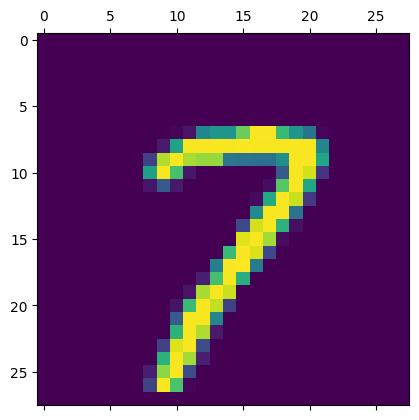

In [22]:
a = x_entrenamiento[230].reshape((28,28))
plt.matshow(a)

In [8]:
y_entrenamiento[20]

4

In [30]:
#Declaramos el numero de clases y el numero de datos que contiene cada imagen
num_clases = 10
num_datos = 784

### Planteamiento

En este caso tenemos 10 clases distintas de datos pues nuestra tarea es clasificar numeros del 0 al 10. Ademas tenemos que las imagenes de los digitos escritos a mano estan representados por matrices de $28\times 28$. Entonces tendremos una matriz $\theta\in \mathbb{R}^{10\times 784}$. Mas aun, tenemos que $b\in\mathbb{R}^{10\times 1}$. Esto nos dice que para una imagen de prueba $x\in\mathbb{R}^{784\times 1}$ nos queda $\theta x + b\in\mathbb{R}^{10\times 1}$, lo que es un vector columna que debera ser evaluado dentro de la funcion $Softmax$.

In [23]:
def softmax(z):
    '''Devuelve el vector de evaluar z en la func. softmax'''
    z_exp = np.exp(z) #Exponenciamos cada entrada
    evaluacion = z_exp / np.sum(z_exp)
    evaluacion = evaluacion.reshape(num_clases, 1)
    return evaluacion

La funcion objetivo que se utilizara sera la "cross-entropy error" la cual esta dada como:

$\bf{L} (\theta, b) = \mathbb{E}_{(X,Y)}[\rho(f(X; \theta, b), Y)]$

donde, $\rho(z, y) = -\displaystyle{\sum_{k=1}^{K} 1_{y=k}\ln(z_k)}$

In [24]:
def cross_entropy_log_loss(z, y):
    '''Funcion cross-entropy error.'''
    return -np.log( z[int(y)] )

Considerando un tamaño de lote $M$, tenemos que la expresion general para el SGD quedaria de la forma:

$\theta^{(j+1)} = \theta^{(j)} - \alpha \displaystyle{\frac{1}{M}\sum_{m=1}^M \nabla_{\theta} \rho (f(x^{(j,m)};\theta^{(j)},b^{(j)}), y^{(j,m)})}$

analogamente,

$b^{(j+1)} = b^{(j)} - \alpha \displaystyle{\frac{1}{M}\sum_{m=1}^M \nabla_{b} \rho (f(x^{(j,m)};\theta^{(j)},b^{(j)}), y^{(j,m)})}$

donde $\alpha$ es la tasa de aprendizaje, $x^{(j,m)}$ es la $m$-esima imagen del paso $j$ y $y^{(j,m)}$ es la clasificacion de $x^{(j,m)}$.

Utilizando la expresion de $\rho (z,y)$ tenemos que

$\nabla_{\theta} \rho (f(x;\theta,b), y)=-\nabla_\theta \ln F_{Softmax}^y(\theta x + b)$

donde $F_{Softmax}^k(z)$ es la $k$-esima entrada del vector resultado de evaluar $z$ en la funcion $Softmax$.

### SGD Estandar

Sea $\theta_k$ el $k$-esimo renglon de la matriz $\theta$. Tenemos dos casos:

Caso 1: $k\neq y$,

$\nabla_{\theta_k} \rho (f(x;\theta,b), y)=-\nabla_{\theta_k} \ln F_{Softmax}^y(\theta x + b)$

$\hspace{2.8cm}=-\displaystyle{\frac{\nabla_{\theta_k} F_{Softmax}^y(\theta x + b)}{F_{Softmax}^y(\theta x + b)}}$

$\hspace{2.8cm}=-\displaystyle{\frac{1}{F_{Softmax}^y(\theta x + b)}\frac{-e^{\theta_y x +b} e^{\theta_k x + b}}{(\sum_{j=1}^K e^{\theta_j x + b})^2}x}$

$\hspace{2.8cm}=\displaystyle{\frac{1}{F_{Softmax}^y(\theta x + b)}F_{Softmax}^y(\theta x + b)F_{Softmax}^k(\theta x + b)x}$

$\hspace{2.8cm}=F_{Softmax}^k(\theta x +b)x$

Caso 2: $k= y$,

$\nabla_{\theta_k} \rho (f(x;\theta,b), y)=-\nabla_{\theta_k} \ln F_{Softmax}^y(\theta x + b)$

$\hspace{2.8cm}=-\displaystyle{\frac{\nabla_{\theta_k} F_{Softmax}^y(\theta x + b)}{F_{Softmax}^y(\theta x + b)}}$

$\hspace{2.8cm}=\displaystyle{\frac{1}{F_{Softmax}^y(\theta x + b)}\frac{e^{\theta_y x +b} e^{\theta_k x + b} - (\sum_{j=1}^K e^{\theta_j x+b})e^{\theta_y x+b}}{(\sum_{j=1}^K e^{\theta_j x + b})^2}x}$

$\hspace{2.8cm}=\displaystyle{\frac{1}{F_{Softmax}^y(\theta x + b)}\frac{e^{\theta_y x + b}[e^{\theta_k x +b}-(\sum_{j=1}^K e^{\theta_j x+b})]}{(\sum_{j=1}^K e^{\theta_j x + b})^2}x}$

$\hspace{2.8cm}=\displaystyle{\frac{1}{F_{Softmax}^y(\theta x + b)}}F_{Softmax}^y(\theta x + b)(F_{Softmax}^k(\theta x + b)-1)x$

$\hspace{2.8cm}=F_{Softmax}^k(\theta x + b)x-x$

Definiendo $e(y) = (1_{y=1}, \dots, 1_{y=K})^T$, tenemos que

$\nabla_{\theta} \rho (f(x;\theta,b), y)=(F_{Softmax}(\theta x + b)-e(y))x$

Para el caso de $\nabla_{b} \rho (f(x;\theta,b), y)$ las cuentas son analogas sin embargo como $b$ no esta multiplicando a $x$, en la regla de la cadena no tenemos el $x$ multiplicando a la expresion anterior. Por lo tanto:

$\nabla_{b} \rho (f(x;\theta,b), y)= F_{Softmax}(\theta x + b)-e(y)$

Finalmente, podemos reescribir las expresiones anteriores para obtener:

$\nabla_{\theta} \rho (f(x;\theta,b), y)= -(e(y) - F_{Softmax}(\theta x + b))x\hspace{1cm}$ y $\hspace{1cm}\nabla_{b} \rho (f(x;\theta,b), y)= -(e(y) - F_{Softmax}(\theta x + b))$

In [25]:
def stochastic_gradient(theta, b, muestra_x, muestra_y):
    '''Funcion que calcula el gradiente con el lote que se haya seleccionado.
    theta: Es la matriz de 10x784 de la iteracion
    b: Es el vector de tamano 10x1 de la iteracion
    muestra_x: Es la componente independiente de la muestra aleatoria de los datos (lote x 784).
    muestra_y: Es un vector de tamano lote que tiene la clasificacion de cada muestra_x.'''

    tamano_lote = muestra_x.shape[0]
    log_lik = 0
    grad_theta_lote = np.zeros_like(theta)
    grad_b_lote = np.zeros_like(b)
    for i in range(tamano_lote):
        x = muestra_x[i] #Recordemos que es de tamano (1x784)
        x = x.reshape((num_datos, 1)) #Transpuesto
        y = muestra_y[i]
        Indicadora = np.matrix(np.zeros((num_clases, 1)))
        Indicadora[y, 0] = 1 #Este es el vector e(y)

        eval_sftmx = softmax(np.matmul(theta, x) + b) #Evaluamos dentro de softmax 
        log_loss = cross_entropy_log_loss(eval_sftmx, y) #Calculamos la logloss del output

        log_lik += log_loss #Sumamos la logloss de ese elem de la muestra

        grad_theta = Indicadora - eval_sftmx #Factor del gradiente
        grad_theta = -grad_theta * x.reshape((1, num_datos)) #Calculo del gradiente
        grad_theta_lote =+ grad_theta #Se suma al grad total

        grad_b = -(Indicadora - eval_sftmx) #Calculo de grad para ese elem del lota
        grad_b_lote =+ grad_b #Se suma al grad total

    return grad_theta_lote / tamano_lote, grad_b_lote / tamano_lote, log_lik

In [26]:
def prec(theta, b, datos_x, datos_y):
    '''Dados los parametros esta funcion calcula la precision de los parametros para predecir
    el resultado correcto y tambien calcula la logloss.
    theta: matriz de 10x784 de la regresion
    datos_x: datos variable independiente (m x 784)
    datos_y: datos variable dependiente (m x 1)'''

    n = len(datos_y) #numero de datos
    theta_t = theta.transpose()
    #probs = [ np.squeeze( softmax( np.matmul(np.matrix(datos_x[i]), theta_t).transpose() ) ) for i in range(n)] #prediccion
    probs = [ np.squeeze( softmax( np.matmul(theta, datos_x[i].reshape(num_datos,1)) + b ) ) for i in range(n)]
    probs = [ np.asarray(p).ravel() for p in probs ] #Conversion de datos
    probs = np.array(probs) #Probas

    pred = np.argmax(probs, axis = 1) #Prediccion
    precision = sum(pred == datos_y) / n #Promedio de aciertos

    loglosses = [cross_entropy_log_loss(probs[i], datos_y[i]) for i in range(n)] #Calculo del logloss
    loss = sum(loglosses) #logloss total
    return loss, precision

In [27]:
def params_0():
    return np.matrix( np.random.randn(num_clases, num_datos) ), np.matrix( np.random.randn(num_clases, 1) )

In [28]:
def SGD(lote, num_iteration, x_entrenam, y_entrenam, x_prueba, y_prueba, theta, b, LR_type, LR = 0.005):
    '''Optimizacion de los parametros via SGD.'''
    
    log_losses = []
    lista_loss = []
    lista_prec = []
    
    for iteration in range(num_iteration):

        #lote_random = np.random.choice(x_entrenam.shape[0], x_entrenam.shape[0], False) #Lote aleatorio
        #num_lotes = int(x_entrenam.shape[0] / lote) #Calculamos los lotes
        #print("Iteracion " + str(iteration))
        lote_random = np.random.choice(x_entrenam.shape[0], lote, False)
        x_lote = x_entrenam[lote_random]
        y_lote = y_entrenam[lote_random]

        grad_theta, grad_b, loss_lote = stochastic_gradient(theta, b, x_lote, y_lote) #gradiente

        if LR_type == "const":
            theta = theta - LR * grad_theta #Actualizacion de los parametros
            b = b - LR * grad_b
        elif LR_type == "lin":
            LR = 1 / (iteration +1) #Asi el primer LR seria 1 pues iteration empieza en cero
            theta = theta - LR * grad_theta #Actualizacion de los parametros
            b = b - LR * grad_b
        elif LR_type == "log":
            LR = 1 / np.log(iteration + 2) #Asi el primer LR seria 1/log(2) pues log(1) = 0
            theta = theta - LR * grad_theta #Actualizacion de los parametros
            b = b - LR * grad_b
        elif LR_type == "sqrt":
            LR = 1 / np.sqrt(iteration + 1) #Asi el primer LR seria 1 pues iteration empieza en cero
            theta = theta - LR * grad_theta #Actualizacion de los parametros
            b = b - LR * grad_b
        log_losses.append(loss_lote)
        
        #loss_entren, prec_entren = prec(theta, b, x_entrenam, y_entrenam) #Este no importa tanto porque es el de entrenamiento
        loss_prueba, prec_prueba = prec(theta, b, x_prueba, y_prueba) #Este es el de prueba es el que importa
        lista_loss.append(loss_prueba) #Los agregamos para ver la evolucion
        lista_prec.append(prec_prueba) #Los agregamos para ver la evolucion

    return theta, b, lista_loss, lista_prec

In [31]:
theta0, b0 = params_0()

In [33]:
lote = 100
num_iteration = 10000
LR = 0.005

In [34]:
theta,b,lista_loss,lista_prec = SGD(lote, num_iteration, x_entrenamiento, y_entrenamiento, x_prueba, y_prueba, theta0, b0, "log")

### Resultados

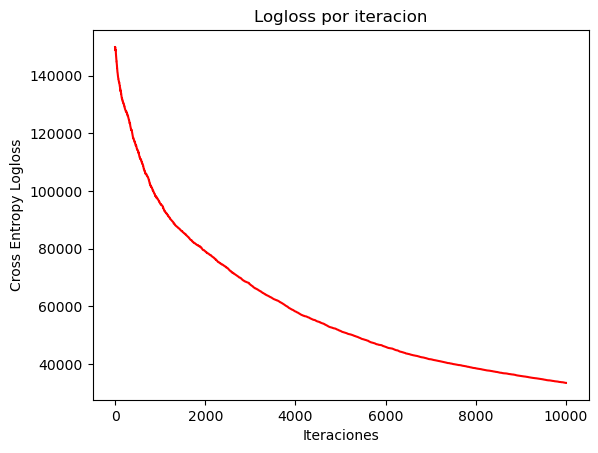

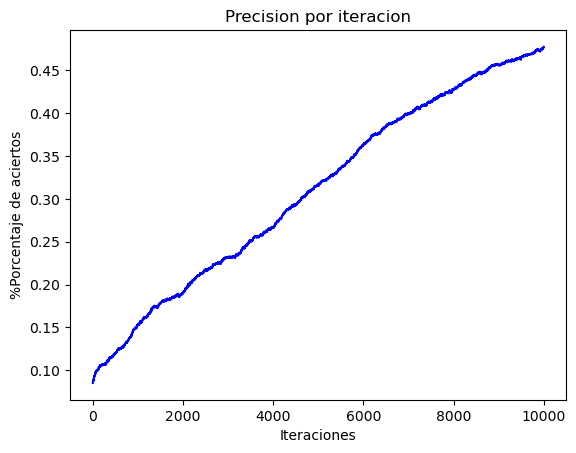

In [20]:
plt.plot(lista_loss, "r-")
plt.xlabel("Iteraciones")
plt.ylabel("Cross Entropy Logloss")
plt.title("Logloss por iteracion")
plt.show()

plt.plot(lista_prec, "b-")
plt.xlabel("Iteraciones")
plt.ylabel("%Porcentaje de aciertos")
plt.title("Precision por iteracion")
plt.show()

Como podemos observar, el metodo estandar puede tardar mucho en converger y vemos que despues de todas las iteraciones solamente logramos alcanzar alrededor de un 45% de precision.

### SGD con Colas Pesadas

Lo anterior nos motiva a introducir colas pesadas a nuestro modelo.

Tenemos que el gradiente descendiente esta dado por

$\theta^{(j+1)}=\theta^{(j)} - \alpha\nabla_\theta \rho (f(x;\theta^{(j)},b^{(j)}), y)$ y analogamente $b^{(j+1)}=b^{(j)} - \alpha\nabla_b \rho (f(x;\theta^{(j)},b^{(j)}), y)$

Abreviando la expresion anterior utilizando $\mu=(\theta, b)$, entonces

$\mu^{(j+1)}=\mu^{(j)} - \alpha\nabla_\mu \rho (f(x;\mu^{(j)}), y)$

Sin embargo, no estamos haciendo gradiente descendiente, sino estamos aplicando su version estocastica. Por lo que, estamos "aproximando" dicho gradiente utilizando un lote:

$\nabla_\mu \rho(f(x;\mu^{(j)}),y) \approx \hat{\nabla}_\mu\rho(f(x;\mu^{(j)}),y) = \displaystyle{\frac{1}{M}\sum_{m=1}^M \nabla_\mu \rho(f(x^{(j,m)};\mu^{(j)}),y^{(j,m)})}$

Lo que haremos a continuacion sera tomar dos aproximaciones provenientes de dos lotes independientes $\hat{\nabla}_\mu\rho(f(x;\mu^{(j)}),y)$ y $\tilde{\nabla}_\mu\rho(f(x;\mu^{(j)}),y)$

De esta forma, podemos aproximar $\nabla_\mu \rho(f(x;\mu^{(j)}),y) \approx \displaystyle{\frac{\hat{\nabla}_\mu\rho(f(x;\mu^{(j)}),y) + \tilde{\nabla}_\mu\rho(f(x;\mu^{(j)}),y)}{2}}$

No obstante, lo anterior no perjudica ni beneficia el SGD. El cambio real consiste en añadir un termino adicional de media cero y varianza grande (infinita).

El termino adicional puede expresarse como $V_j\displaystyle{\frac{\hat{\nabla}_\mu\rho(f(x;\mu^{(j)}),y) - \tilde{\nabla}_\mu\rho(f(x;\mu^{(j)}),y)}{2}}$ donde $(V_n)_n$ es una sucesion de variables aleatorias independientes, identidamente distribuidas de media acotada y varianza no acotada. Tambien es importante mencionar que dichas v.a. son independientes de la eleccion del lote.

La expresion anterior tiene media cero pues como la eleccion del lote es aleatoria e independiente tanto entre si como de la $V_j$, entonces $V_j\hat{\nabla}_\mu\rho(f(x;\mu^{(j)}),y)$ y $V_j\tilde{\nabla}_\mu\rho(f(x;\mu^{(j)}),y)$ tienen la misma distribucion, lo que ocasiona que la diferencia tenga media cero siempre y cuando $V_j$ tenga media finita.

La expresion quedaria entonces de la forma:

$\nabla_\mu \rho(f(x;\mu^{(j)}),y) \approx \displaystyle{\frac{\hat{\nabla}_\mu\rho(f(x;\mu^{(j)}),y) + \tilde{\nabla}_\mu\rho(f(x;\mu^{(j)}),y)}{2}} + V_j\displaystyle{\frac{\hat{\nabla}_\mu\rho(f(x;\mu^{(j)}),y) - \tilde{\nabla}_\mu\rho(f(x;\mu^{(j)}),y)}{2}}$

Asi, la actualizacion de los parametros para el SGD quedaria:

$\mu^{(j+1)}=\mu^{(j)} - \alpha\left( \displaystyle{\frac{\hat{\nabla}_\mu\rho(f(x;\mu^{(j)}),y) + \tilde{\nabla}_\mu\rho(f(x;\mu^{(j)}),y)}{2}} + V_j\displaystyle{\frac{\hat{\nabla}_\mu\rho(f(x;\mu^{(j)}),y) - \tilde{\nabla}_\mu\rho(f(x;\mu^{(j)}),y)}{2}}\right)$

Ahora, lo unico que hace falta es una v.a. que tenga media finita y varianza no finita.

Para lo anterior, utilizaremos la distribucion Pareto. Se dice que $X\sim Pareto(\alpha, x_m)$ si su funcion de densidad es: $f_X(x)=\displaystyle{\frac{\alpha x_m^\alpha}{x^{\alpha +1}}}$ para $x\geq x_m$.

Usando la funcion de densidad tenemos que, la funcion de distribucion esta dada por: $F_X(x)=\displaystyle{\int_{x_m}^x \frac{\alpha x_m^\alpha}{y^{\alpha+1}}dy = 1-\left(\frac{x_m}{x}\right)^\alpha}$

Utilizando el teorema de inversion, tenemos que si $U\sim Unif(0,1)$ entonces $\displaystyle{\frac{x_m}{(1-U)^{1 / \alpha}}}\sim Pareto(\alpha, x_m)$

Un aspecto particular de la distribucion pareto es que el $n$-esimo momento solamente esta definido para $n < \alpha$ y esta dado por $\mathbb{E}(X^n) = \displaystyle{\frac{\alpha x_m ^n}{\alpha - n}}$

Lo que queremos es que tenga media acotada y varianza no acotada, por lo tanto la eleccion de parametros tentativos son $\alpha=2$ y $x_m=1$ para que cumpla lo anterior y ademas tenga soporte en $[1,\infty)$.

In [17]:
def Pareto(alpha = 2, x_m = 1):
    '''Regresa un valor simulado de una distribucion pareto de parametros alpha y x_m'''
    U = np.random.random() #Uniforme(0,1)
    return x_m / (U ** (1 / alpha)) # 1-U distribuye igual que U

Con lo anterior implementado podemos incluirlo dentro del codigo.

In [18]:
def SGD_HT(lote, num_iteration, x_entrenam, y_entrenam, x_prueba, y_prueba, theta, b, LR_type, LR = 0.005, x_m = 1.0):
    '''Optimizacion de los parametros via SGD con colas pesadas.'''
    
    log_losses = []
    lista_loss = []
    lista_prec = []
    
    for iteration in range(num_iteration):

        #lote_random = np.random.choice(x_entrenam.shape[0], x_entrenam.shape[0], False) #Lote aleatorio
        #num_lotes = int(x_entrenam.shape[0] / lote) #Calculamos los lotes
        #print("Iteracion " + str(iteration))
        lote_random_1 = np.random.choice(x_entrenam.shape[0], lote, False)
        lote_random_2 = np.random.choice(x_entrenam.shape[0], lote, False)

        x_lote_1 = x_entrenam[lote_random_1]
        y_lote_1 = y_entrenam[lote_random_1]

        x_lote_2 = x_entrenam[lote_random_2]
        y_lote_2 = y_entrenam[lote_random_2]

        grad_theta_1, grad_b_1, loss_lote_1 = stochastic_gradient(theta, b, x_lote_1, y_lote_1) # gradiente 1
        grad_theta_2, grad_b_2, loss_lote_2 = stochastic_gradient(theta, b, x_lote_2, y_lote_2) # gradiente 2

        if LR_type == "const":
            V = Pareto() #Simulacion Pareto
            theta = theta - LR * 0.5 * (grad_theta_1 + grad_theta_2) - LR * V * 0.5 * ( grad_theta_1 - grad_theta_2 ) #Actualizacion
            b = b - LR * 0.5 * (grad_b_1 + grad_b_2) - LR * V * 0.5 * ( grad_b_1 - grad_b_2 )
        elif LR_type == "lin":
            LR = 1 / (iteration +1) #Asi el primer LR seria 1 pues iteration empieza en cero
            V = Pareto() #Simulacion Pareto
            theta = theta - LR * 0.5 * (grad_theta_1 + grad_theta_2) - LR * V * 0.5 * ( grad_theta_1 - grad_theta_2 ) #Actualizacion
            b = b - LR * 0.5 * (grad_b_1 + grad_b_2) - LR * V * 0.5 * ( grad_b_1 - grad_b_2 )
        elif LR_type == "log":
            LR = 1 / np.log(iteration + 2) #Asi el primer LR seria 1/log(2) pues log(1) = 0
            V = Pareto()
            theta = theta - LR * 0.5 * (grad_theta_1 + grad_theta_2) - LR * V * 0.5 * ( grad_theta_1 - grad_theta_2 ) #Actualizacion
            b = b - LR * 0.5 * (grad_b_1 + grad_b_2) - LR * V * 0.5 * ( grad_b_1 - grad_b_2 )
        elif LR_type == "sqrt":
            LR = 1 / np.sqrt(iteration + 1) #Asi el primer LR seria 1 pues iteration empieza en cero
            V = Pareto()
            theta = theta - LR * 0.5 * (grad_theta_1 + grad_theta_2) - LR * V * 0.5 * ( grad_theta_1 - grad_theta_2 ) #Actualizacion
            b = b - LR * 0.5 * (grad_b_1 + grad_b_2) - LR * V * 0.5 * ( grad_b_1 - grad_b_2 )
        
        #log_losses.append(loss_lote_1)
        
        #loss_entren, prec_entren = prec(theta, b, x_entrenam, y_entrenam) #Este no importa tanto porque es el de entrenamiento
        loss_prueba, prec_prueba = prec(theta, b, x_prueba, y_prueba) #Este es el de prueba es el que importa
        lista_loss.append(loss_prueba) #Los agregamos para ver la evolucion
        lista_prec.append(prec_prueba) #Los agregamos para ver la evolucion

    return theta, b, lista_loss, lista_prec

Ahora, haremos el estudio para analizar los resultados.

In [23]:
#theta_HT, b_HT = params_0()

In [24]:
num_iteration = 10000

In [25]:
theta_HT,b_HT,lista_loss_HT,lista_prec_HT = SGD_HT(lote, num_iteration, x_entrenamiento, y_entrenamiento, x_prueba, y_prueba, theta0, b0, "log")

In [35]:
#np.savetxt("parameters_theta_adv.csv", theta_HT, delimiter = ",")
#np.savetxt("paremeters_b_adv.csv", b_HT, delimiter = ",")

### Resultados

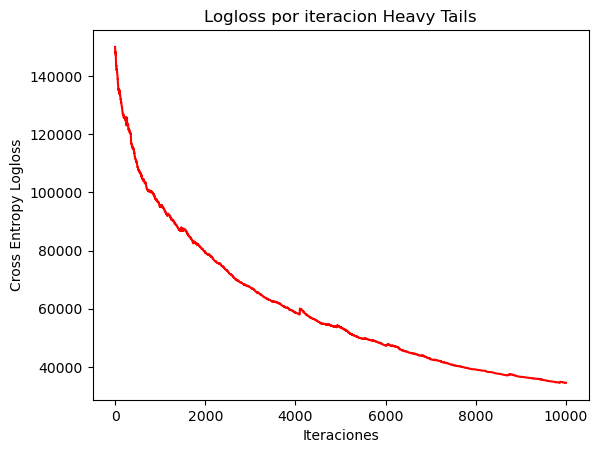

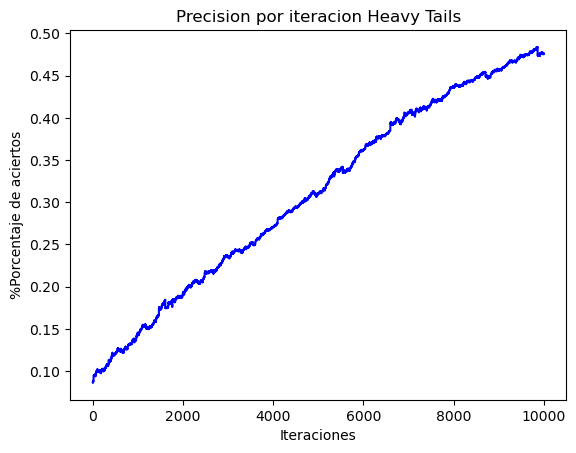

In [26]:
plt.plot(lista_loss_HT, "r-")
plt.xlabel("Iteraciones")
plt.ylabel("Cross Entropy Logloss")
plt.title("Logloss por iteracion Heavy Tails")
plt.show()

plt.plot(lista_prec_HT, "b-")
plt.xlabel("Iteraciones")
plt.ylabel("%Porcentaje de aciertos")
plt.title("Precision por iteracion Heavy Tails")
plt.show()

Observamos que pertiendo desde nuestros $(\theta_0,b_0)$ el SGD de colas pesadas parece avanzar mas rapido y reducir el error mas rapido y alancazar una mayor precision de alrededor 50% con las mismas iteraciones.

### SGD con Colas Pesadas y Clipping

Como mencionamos anteriormente, uno de las posibles contras de introducir colas pesadas al SGD es que al multiplicar por una v.a. con varianza no finita, puede causar que la norma de los incrementos sean muy grandes y esto puede ocasionar que la trayectoria que siguen los parametros no sea corregida a tiempo, lo que se traduciria en que se tardaria mas en converger.

Analicemos la expresion del SGD con colas pesadas:

$\mu^{(j+1)}=\mu^{(j)} - \alpha\left( \displaystyle{\frac{\hat{\nabla}_\mu\rho(f(x;\mu^{(j)}),y) + \tilde{\nabla}_\mu\rho(f(x;\mu^{(j)}),y)}{2}} + V_j\displaystyle{\frac{\hat{\nabla}_\mu\rho(f(x;\mu^{(j)}),y) - \tilde{\nabla}_\mu\rho(f(x;\mu^{(j)}),y)}{2}}\right)$

Observemos que toda la expresion entre parentesis es un vector que puede tomar una norma muy grande que es ocasionada por la v.a. $V_j$. En este sentido, lo que buscamos controlar es dicha norma para evitar que los saltos sean tan largos.

Para lo anterior, definimos la funcion $Clip_r$ de la siguiente forma:

$Clip_r(z)=\displaystyle{\frac{z}{||z||_2}\min\{||z||_2,r\}}$, para $z\in\mathbb{R}^{n\times m}$

Observemos que al aplicar $Clip_r$ a una matriz lo que logramos es que preservar la direccion pero tomando el minimo de su norma original y $r$ con lo cual controlamos la norma.

Podemos reescribir la funcion $Clip$ para quedar de la forma:

$Clip_r(z)=\displaystyle{z\min\left\{1,\frac{r}{||z||_2}\right\}}$, para $z\in\mathbb{R}^{n\times m}$

In [19]:
def Clip(z, r):
    '''Aplica clipping(r) al vector (matriz) z'''
    return z * min(1, r / np.linalg.norm(z) )

Ahora que hemos definido dicha funcion, el SGD con Clipping se define por utilizar la siguiente expresion para actualizar los parametros:

$\mu^{(j+1)}=\mu^{(j)} - \alpha~ Clip_r\left( \displaystyle{\frac{\hat{\nabla}_\mu\rho(f(x;\mu^{(j)}),y) + \tilde{\nabla}_\mu\rho(f(x;\mu^{(j)}),y)}{2}} + V_j\displaystyle{\frac{\hat{\nabla}_\mu\rho(f(x;\mu^{(j)}),y) - \tilde{\nabla}_\mu\rho(f(x;\mu^{(j)}),y)}{2}}\right)$

In [20]:
def SGD_Clip(lote, num_iteration, x_entrenam, y_entrenam, x_prueba, y_prueba, theta, b, LR_type, r, LR = 0.005, x_m = 1.0):
    '''Optimizacion de los parametros via SGD con colas pesadas.'''
    
    log_losses = []
    lista_loss = []
    lista_prec = []
    
    for iteration in range(num_iteration):

        #lote_random = np.random.choice(x_entrenam.shape[0], x_entrenam.shape[0], False) #Lote aleatorio
        #num_lotes = int(x_entrenam.shape[0] / lote) #Calculamos los lotes
        #print("Iteracion " + str(iteration))
        lote_random_1 = np.random.choice(x_entrenam.shape[0], lote, False)
        lote_random_2 = np.random.choice(x_entrenam.shape[0], lote, False)

        x_lote_1 = x_entrenam[lote_random_1]
        y_lote_1 = y_entrenam[lote_random_1]

        x_lote_2 = x_entrenam[lote_random_2]
        y_lote_2 = y_entrenam[lote_random_2]

        grad_theta_1, grad_b_1, loss_lote_1 = stochastic_gradient(theta, b, x_lote_1, y_lote_1) # gradiente 1
        grad_theta_2, grad_b_2, loss_lote_2 = stochastic_gradient(theta, b, x_lote_2, y_lote_2) # gradiente 2

        if LR_type == "const":
            V = Pareto() #Simulacion Pareto
            z = 0.5 * (grad_theta_1 + grad_theta_2) + V * 0.5 * ( grad_theta_1 - grad_theta_2 )
            theta = theta - LR * Clip(z, r) #Actualizacion
            z = 0.5 * (grad_b_1 + grad_b_2) + V * 0.5 * ( grad_b_1 - grad_b_2 )
            b = b - LR * Clip(z, r)
        elif LR_type == "lin":
            LR = 1 / (iteration +1) #Asi el primer LR seria 1 pues iteration empieza en cero
            V = Pareto() #Simulacion Pareto
            z = 0.5 * (grad_theta_1 + grad_theta_2) + V * 0.5 * ( grad_theta_1 - grad_theta_2 )
            theta = theta - LR * Clip(z, r) #Actualizacion
            z = 0.5 * (grad_b_1 + grad_b_2) + V * 0.5 * ( grad_b_1 - grad_b_2 )
            b = b - LR * Clip(z, r)
        elif LR_type == "log":
            LR = 1 / np.log(iteration + 2) #Asi el primer LR seria 1/log(2) pues log(1) = 0
            V = Pareto()
            z = 0.5 * (grad_theta_1 + grad_theta_2) + V * 0.5 * ( grad_theta_1 - grad_theta_2 )
            theta = theta - LR * Clip(z, r) #Actualizacion
            z = 0.5 * (grad_b_1 + grad_b_2) + V * 0.5 * ( grad_b_1 - grad_b_2 )
            b = b - LR * Clip(z, r)
        elif LR_type == "sqrt":
            LR = 1 / np.sqrt(iteration + 1) #Asi el primer LR seria 1 pues iteration empieza en cero
            V = Pareto()
            z = 0.5 * (grad_theta_1 + grad_theta_2) + V * 0.5 * ( grad_theta_1 - grad_theta_2 )
            theta = theta - LR * Clip(z, r) #Actualizacion
            z = 0.5 * (grad_b_1 + grad_b_2) + V * 0.5 * ( grad_b_1 - grad_b_2 )
            b = b - LR * Clip(z, r)
        
        #log_losses.append(loss_lote_1)
        
        #loss_entren, prec_entren = prec(theta, b, x_entrenam, y_entrenam) #Este no importa tanto porque es el de entrenamiento
        loss_prueba, prec_prueba = prec(theta, b, x_prueba, y_prueba) #Este es el de prueba es el que importa
        lista_loss.append(loss_prueba) #Los agregamos para ver la evolucion
        lista_prec.append(prec_prueba) #Los agregamos para ver la evolucion

    return theta, b, lista_loss, lista_prec

In [29]:
#theta_c, b_c = params_0()

In [21]:
num_iteration = 10000
r = 1

In [31]:
theta_c,b_c,lista_loss_c,lista_prec_c = SGD_Clip(lote, num_iteration, x_entrenamiento, y_entrenamiento, x_prueba, y_prueba, theta0, b0, "log", r)

### Resultados

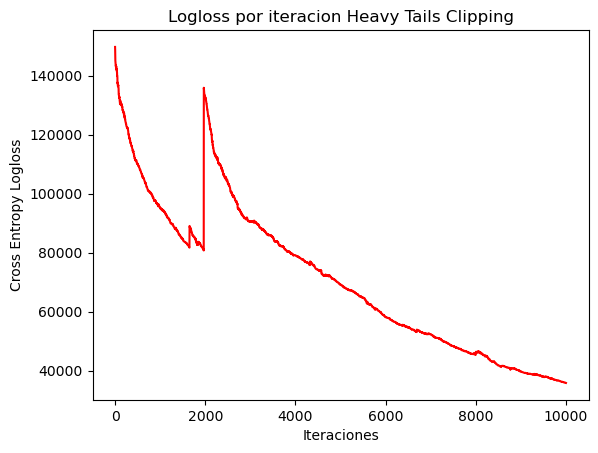

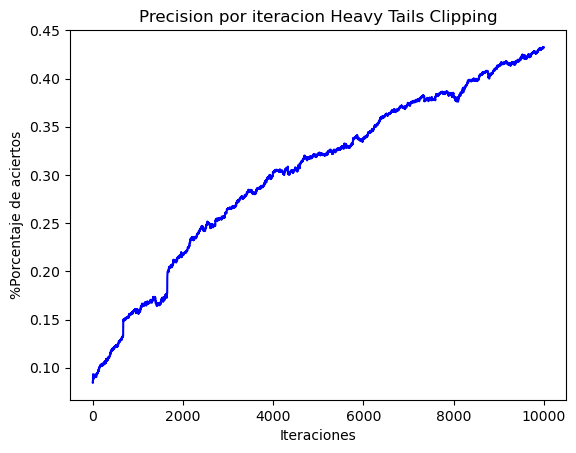

In [32]:
plt.plot(lista_loss_c, "r-")
plt.xlabel("Iteraciones")
plt.ylabel("Cross Entropy Logloss")
plt.title("Logloss por iteracion Heavy Tails Clipping")
plt.show()

plt.plot(lista_prec_c, "b-")
plt.xlabel("Iteraciones")
plt.ylabel("%Porcentaje de aciertos")
plt.title("Precision por iteracion Heavy Tails Clipping")
plt.show()

Podemos observar que al añadir clipping se tiene un performance similar al del SGD Estandar ya que se alcanza una precision alrededor del 45%.

### Analisis Cerca del "Optimo"

En general podriamos concluir que el SGD con colas pesadas se acerca mas rapido al "optimo". Sin embargo, algo que nos interesaria saber tambien es como se comporta cada una de estas variantes al estar cerca del "optimo".

Para poder realizar el analisis anterior, se utilizaran parametros que se obtuvieron al correr el SGD de colas pesadas (que es el que se acerca mas rapido) alrededor de $30,000-45,000$ iteraciones.

In [22]:
theta = np.loadtxt(open("parameters_theta.csv", "rb"), delimiter=",")
theta = np.matrix(theta)
theta

matrix([[-0.44505246, -0.64613115,  1.03986111, ...,  1.73287859,
         -0.35374625, -1.96610701],
        [ 1.63248873, -1.78130746,  1.2343639 , ...,  1.23495956,
         -0.4054635 ,  0.60280764],
        [ 0.19668351,  1.2984801 , -1.17598404, ..., -0.12909811,
         -2.05981311, -0.47193715],
        ...,
        [-0.40416203, -1.87744226,  0.05358238, ..., -2.30388639,
         -1.71104288, -0.31181544],
        [-0.87482116, -0.64333706,  0.74090781, ...,  0.80732517,
         -0.58185516, -1.21496   ],
        [ 0.97767733, -0.35893902,  0.80398375, ..., -1.61821163,
         -0.75167882, -0.74862169]])

In [23]:
b = np.loadtxt(open("parameters_b.csv", "rb"), delimiter=",")
b = np.matrix(b)
b = b.reshape((10,1))
b

matrix([[-0.82516586],
        [ 1.61417293],
        [-0.99493918],
        [-1.21285196],
        [-0.87446286],
        [-0.20911868],
        [-1.12937344],
        [-0.36874382],
        [-1.84105169],
        [-0.0117451 ]])

In [24]:
num_iteration = 3000

### SGD Estandar cerca del "Optimo"

In [25]:
theta_n,b_n,lista_loss,lista_prec = SGD(lote, num_iteration, x_entrenamiento, y_entrenamiento, x_prueba, y_prueba, theta, b, "log")

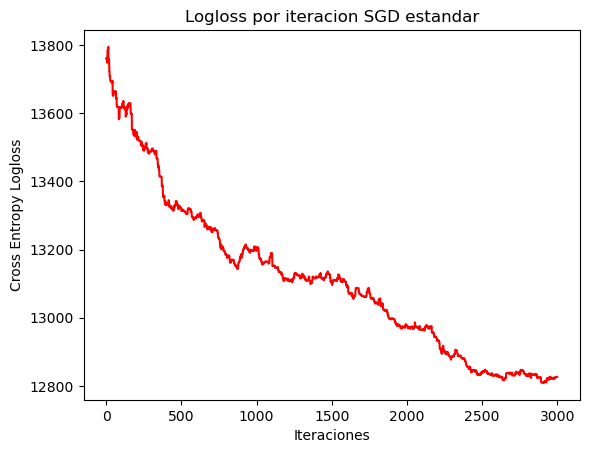

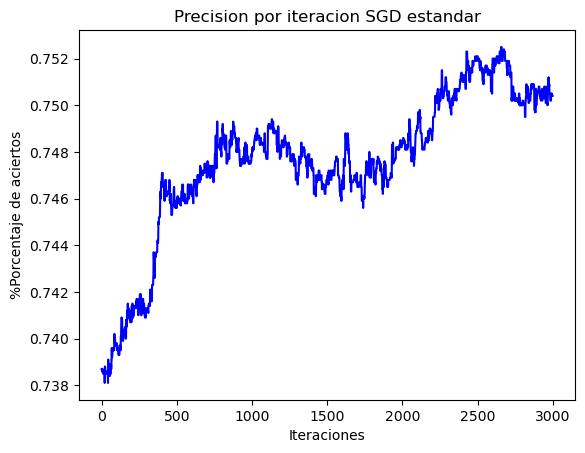

In [26]:
plt.plot(lista_loss, "r-")
plt.xlabel("Iteraciones")
plt.ylabel("Cross Entropy Logloss")
plt.title("Logloss por iteracion SGD estandar")
plt.show()

plt.plot(lista_prec, "b-")
plt.xlabel("Iteraciones")
plt.ylabel("%Porcentaje de aciertos")
plt.title("Precision por iteracion SGD estandar")
plt.show()

Podemos observar que el comportamiento del SGD Estandar tiene un comportamiento similar al que habiamos observado antes con nuestros parametros $(\theta_0, b_0)$

### SGD Colas Pesadas

In [27]:
theta_HT,b_HT,lista_loss_HT,lista_prec_HT = SGD_HT(lote, num_iteration, x_entrenamiento, y_entrenamiento, x_prueba, y_prueba, theta, b, "log")

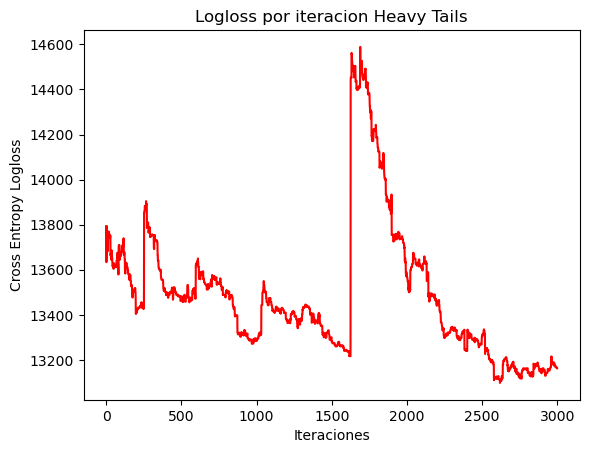

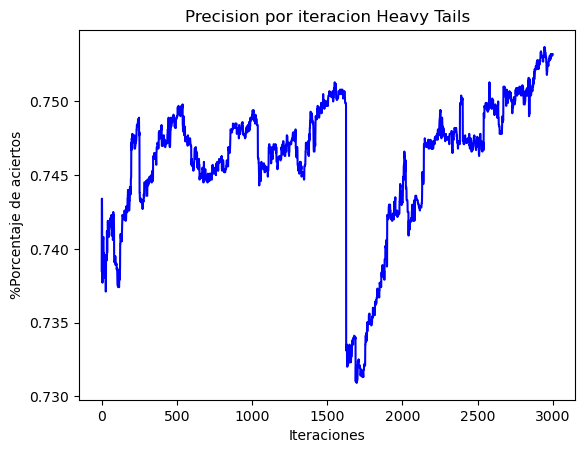

In [28]:
plt.plot(lista_loss_HT, "r-")
plt.xlabel("Iteraciones")
plt.ylabel("Cross Entropy Logloss")
plt.title("Logloss por iteracion Heavy Tails")
plt.show()

plt.plot(lista_prec_HT, "b-")
plt.xlabel("Iteraciones")
plt.ylabel("%Porcentaje de aciertos")
plt.title("Precision por iteracion Heavy Tails")
plt.show()

Observemos que el SGD de colas pesadas tiene un comportamiento erratico pues tanto el error como la precision tiene subidas y bajadas.

### SGD con Colas Pesadas y Clipping

In [29]:
theta_c,b_c,lista_loss_c,lista_prec_c = SGD_Clip(lote, num_iteration, x_entrenamiento, y_entrenamiento, x_prueba, y_prueba, theta, b, "log", r)

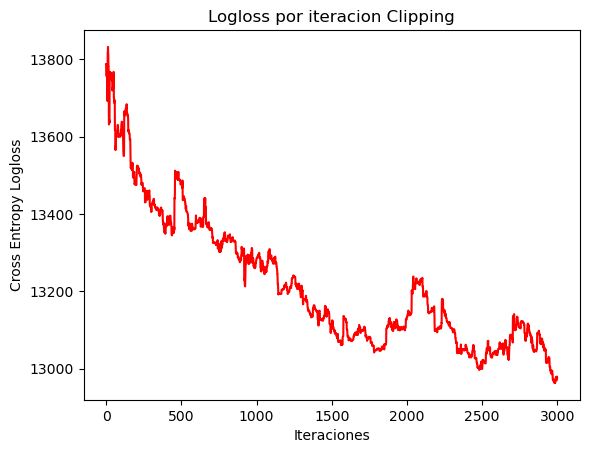

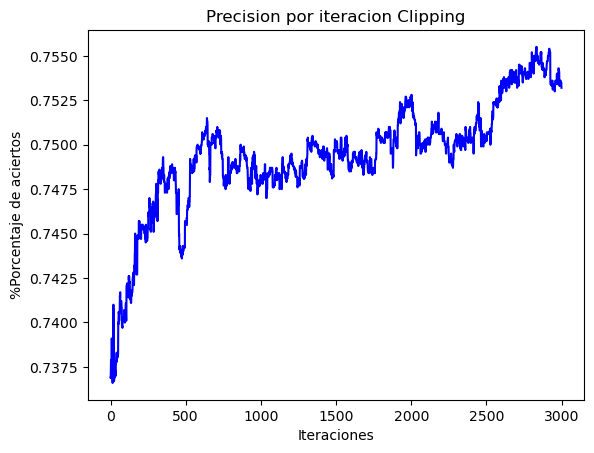

In [30]:
plt.plot(lista_loss_c, "r-")
plt.xlabel("Iteraciones")
plt.ylabel("Cross Entropy Logloss")
plt.title("Logloss por iteracion Clipping")
plt.show()

plt.plot(lista_prec_c, "b-")
plt.xlabel("Iteraciones")
plt.ylabel("%Porcentaje de aciertos")
plt.title("Precision por iteracion Clipping")
plt.show()

Podemos observar de estos resultados que añadir clipping a las colas pesadas nos da un comportamiento superior al del SGD Estandar y el SGD de Colas Pesadas pues tanto el error como la precision se comporta menos erratico que el de colas pesadas y tiene un performance mayor que el SGD estandar.

In [ ]:
#np.savetxt("parameters_theta.csv", theta, delimiter = ",")
#np.savetxt("parameters_b.csv", b, delimiter = ",")

### Conclusiones

Como podemos observar, cuando los parametros se encuentran cerca del "optimo", las diferentes variantes del SGD tienen comportamientos diferentes.

Comenzando por el "SGD Estandar", tiene una convergencia lenta hacia el optimo ya sea si se le coloca cerca o lejos del optimo. No obstante, si lo comparamos con el SGD de Colas Pesadas este ultimo tiene mejor performance cuando se esta lejos del optimo, esto nos hace sentido pues las colas pesadas tienen un comportamiento mas erratico y esto ocasiona que cerca del optimo "reboten" y haya mayor dificultad de alcanzarlo. En contraste con los anteriores, añadir Clipping parece tener un comportamiento similar al del SGD Estandar si se esta lejos del optimo, no obstante su comportamiento cerca del optimo es el mejor de los 3 ya que continua dando saltos mas grande que el SGD Estandar pero sin presentar el comportamiento erratico del SGD de Colas Pesadas.